# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
import optuna

import warnings
warnings.filterwarnings('ignore') # отключаем уведомления системы

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('https://lms-cdn.skillfactory.ru/assets/courseware/v1/71b705fb3dda956399b2209697366543/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/_unconv.zip')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [3]:
#посмотрим на типы представленных данных и оценим есть ли в них пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [4]:
#посмотрим на статистические характеристики
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


**Выводы**

В дата сете 7 значимых (без номера скважины) числовых признаков, каждый из которых имеет различный масштаб и диапазон. Наибольшиий разброс (от 10 до 85) у коэффициента хрупкости скважины ($Brittle$), а наименьший - у коэффициента отражения витринита ($VR$) и показателя общего органического углерода $TOC$ от (-0.19 до 2.18). Причём у последнего присуствуют и отрицательные значения. Пропуски отсутствуют.

#### **Посмотрим распределение целевого показателя**

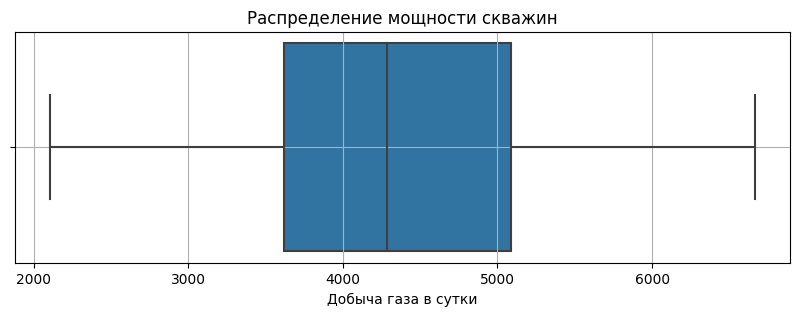

In [5]:
fig = plt.figure(figsize=(10, 3))
boxplot = sns.boxplot(
    data=data,
    x='Prod',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение мощности скважин');
boxplot.set_xlabel('Добыча газа в сутки');
boxplot.grid()

По графику можно сказать, что большинство скважин добывают от 3500 до 5000 $м^3$ газа в сутки.

#### **Оценим распределение наблюдений**

In [6]:
# Создаём список категориальных признаков без номера скважины и целевого признака
features = list(data.columns)
features.remove('Well')
features.remove('Prod')

# Создаём словарь наименований и значений признаков
features_name = {
                'Por':'пористость скважины (%)', 
                'Perm':'проницаемость скважины',
                'AI':'акустический импеданс (кг/кв.м * 10^6)',
                'Brittle':'коэффициент хрупкости скважины (%)',
                'TOC': 'общий органический углерод (%)',
                'VR':'коэффициент отражения витринита (%)'
}

In [7]:
# Создаём подграфики:
ncols = 2
nrows = 3
fig = make_subplots(rows=nrows, cols=ncols)

for i, df_column in enumerate(features):
    row = i // ncols + 1  # определяем номер ряда
    col = i % ncols + 1  # определяем номер столбца
    histogram = go.Histogram(x=data[df_column])  # создаем гистограмму
    fig.add_trace(histogram, row=row, col=col)  # добавляем гистограмму на подграфик

fig.update_layout(height=800, width=1000, showlegend=False).show();


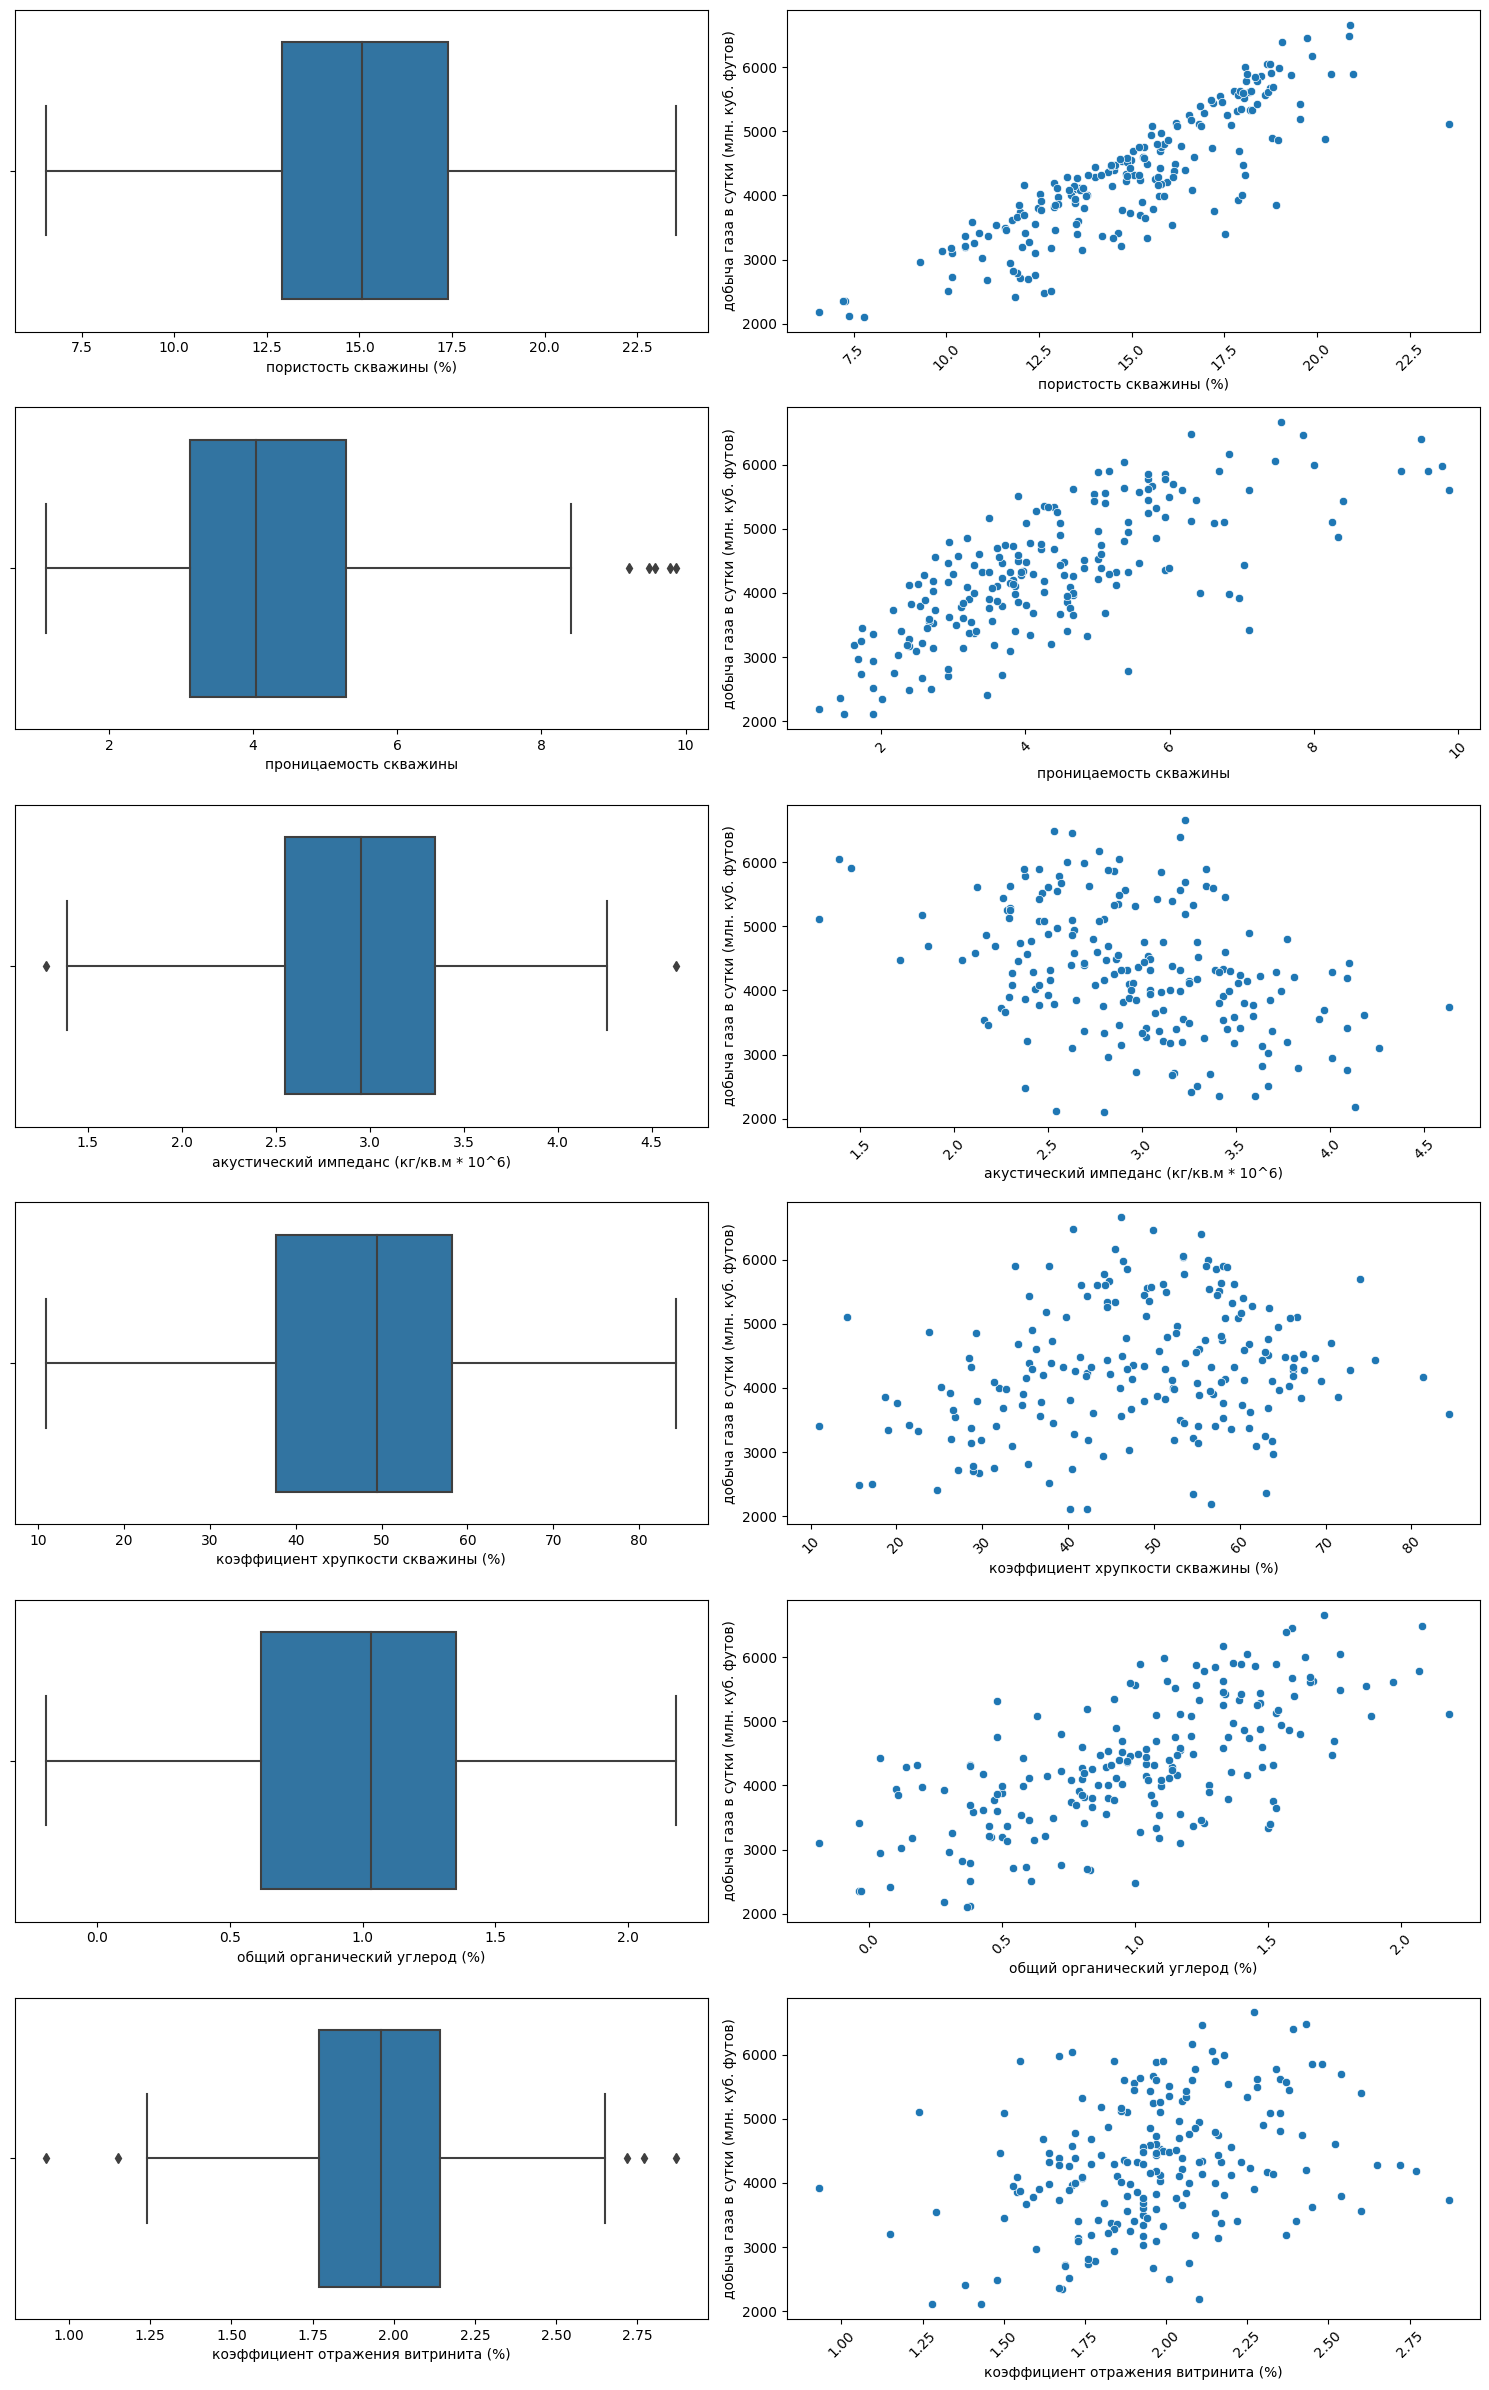

In [8]:
fig, axes = plt.subplots(len(features), 2, figsize=(15, 4*len(features))) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в признаке
    boxplot = sns.boxplot(data=data, x=feature, orient='h', ax=axes[i][0])
    boxplot.set(xlabel=features_name[feature])
    #Строим столбчатую диаграмму количества клиентов в разрезе согласия на депозит по каждому признаку
    scatterplot = sns.scatterplot(data=data, x=feature,  y='Prod', ax=axes[i][1])
    #повернём подписи на 45 градусов для удобочитаемости
    scatterplot.xaxis.set_tick_params(rotation=45)
    #подпишем каждый график по оси Х (берём данные из словаря) и Y
    scatterplot.set(xlabel=features_name[feature], ylabel="добыча газа в сутки (млн. куб. футов)")
plt.tight_layout() #выравнивание графиков

**Выводы**

Судя по графикам рассеяния, проследивается прямая зависимость объёма добычи от пористости скважины ($Por$), а также, хоть и менее значительно, от проницаемости ($Perm$) и содержания общего органического углерода ($TOC$), тода как с ростом аккустического импенданса ($AI$), наоборот, мощность скважины  уменьшается. 

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [9]:
corr = data.corr()
print('Количество факторов:', corr.shape[1])
print('Pанг корреляционой матрицы: ',np.linalg.matrix_rank(corr))
print('Определитель корреляционой матрицы: {:.7f}'.format(np.linalg.det(corr)))
corr.style.background_gradient()

Количество факторов: 8
Pанг корреляционой матрицы:  8
Определитель корреляционой матрицы: 0.0007299


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


**Выводы:**

- Полученная кореляционная матрица подтверждает выводы после анализа графиков. Мы видим сильную связь между целевой переменной Prod и признаками Por (пористость скважины) и Perm (проницаемость скважины). Средняя связь видна между целевой переменной Prod и показателем TOC (общий органический углерод). а вот с показателем AI (акустический импеданс) существует обратная, но слабая связь.
- Если рассматривать корреляцию между показателями, то мы видим сильную связь между признаками Por (пористость скважины) и Perm (проницаемость скважины), а также Por (пористость скважины) и TOC (общий органический углерод). 
- Средняя связь между показателями Perm (проницаемость скважины) и TOC (общий органический углерод), а также VR (коэффициент отражения витринита) и AI (акустический импеданс)
- Количество факторов совпадает с рангом матрицы, а определитель матрицы не равен 0, а значит матрица невыроженная, поэтому мы можем использовать МНК. 

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [10]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = np.column_stack((np.ones(200),data['Well'],data['Por'],data['Perm'],data['AI'],data['Brittle'],data['TOC'],data['VR']))
y = data[['Prod']]
# Применяем формулу OLS-оценки для коэффициентов
w = np.linalg.inv(X.T@X)@X.T@y
for i in range(len(w.values)):
    if i == 0:
        print ('Нулевой коэффициент W_' + str(i) + ':', int(w.iloc[i]))
    else:
        print ('Коэффициент W_' + str(i) + ' (признак',data.columns[i-1] + '):', int(w.iloc[i]))

Нулевой коэффициент W_0: -1232
Коэффициент W_1 (признак Well): 0
Коэффициент W_2 (признак Por): 230
Коэффициент W_3 (признак Perm): 116
Коэффициент W_4 (признак AI): -365
Коэффициент W_5 (признак Brittle): 24
Коэффициент W_6 (признак TOC): -78
Коэффициент W_7 (признак VR): 785


**Выводы**

- Среди полученных коэфициентов определён неинформативный коэффициент $w_1$, который соотвествует номеру скважины ($Well$) и не несёт никакой смысловой нагрузки и может не учитываться при построении модели. 
- Отрицательное значение коэффициента $w_4$ подтверждает обратную зависимость целевого показателя от признака $AI$, что было выявлено ранее
- Так как значения показателей имеют разный масштаб, то и полученные коэффициенты существенно отличаются друг от друга, что не позволяет выявить наиболее важные признаки.


### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [11]:
def mean_absolute_error(y_true, pred): #
    return np.mean(np.abs(y_true - pred))

In [12]:
#объявляе словарь с новымыи значениями
dict_106 ={'Well': 106.0,
            'Por': 15.32,
            'Perm': 3.71,
            'AI': 3.29,
            'Brittle': 55.99,
            'TOC': 1.35,
            'VR': 2.42}
y_106 = 4748.315024

#формируем вектор-строку из новых значений. Не забываем первым элементом поставить 1
list_106 = np.array([1])
for i in dict_106.values():
    list_106 = np.append(list_106, i)

# делаем прогноз на основе полученных коэфициентов
print('Прогноз целевой переменной по новым данным: {:.2f}'.format(float((list_106@w).values)))
print('Абсолютная ошибка между предсказанным значением и истинным значением: {:.2f}'.format(abs(y_106-float((list_106@w).values))))
print()
y_pred = np.ones(200)
mae = mape = 0
#расчитываем прогноз выборки для всех скважин из обучающегно набора и абсолютную ошибку
for i in range(X.shape[0]):
    y_pred[i] = X[i]@w
    mae += abs(y.values[i]-y_pred[i])
    mape += mae/abs(y.values[i])

#рассчитываем метрики ошибки MAE и MAPE
mae = mae/X.shape[0]
mape = mape/X.shape[0]
print ('Абсолютная ошибка модели на тренировочных данных: {:.2f}'.format(float(mae)))
print ('Абсолютная ошибка модели в процентах: {:.2f}%'.format(float(mape)))


Прогноз целевой переменной по новым данным: 4723.06
Абсолютная ошибка между предсказанным значением и истинным значением: 25.25

Абсолютная ошибка модели на тренировочных данных: 153.62
Абсолютная ошибка модели в процентах: 3.73%


**Вывод**

Полученная модель в среднем ошибается на 153,62 млн. куб. футов, что составляет 3,73% от среднего показателя добычи газа.   

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

**Выводы**

- Отрицательное значение коэффициента $w_6$ означает обратную зависимость целевого показателя от показателя общего органического углерода ($TOC$), что противоречит данным, полученным с помощью корреляционной матрицы.
- Небольшое значение коэфициента $w_5$ (коэффициент хрупкости скважины $Brittle$) обусловленно наибольшим разбросом значений этого показателя.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [13]:
# создаём матрицу из интересующих нас показателей 
X = np.column_stack((np.ones(200), data['Por'], data['AI'], data['Brittle'], data['TOC'], data['VR']))
# создаём список показателей без целевого и показателей с сильной и слабой корреляцией с ним
columns = list(data.columns)
columns.remove('Prod')
columns.remove('Well')
columns.remove('Perm')
y = data[['Prod']]
# Применим формулу OLS-оценки для коэффициентов
w = np.linalg.inv(X.T@X)@X.T@y
for i in range(len(w.values)):
    if i == 0:
        print ('Нулевой коэффициент W_' + str(i) + ':', int(w.iloc[i]))
    else:
        print ('Коэффициент W_' + str(i) + ' (признак',columns[i-1] + '):', int(w.iloc[i]))
        
print()
y_pred = np.ones(200)
mae = mape = 0
#расчитываем прогноз выборки для всех скважин из обучающегно набора и абсолютную ошибку
for i in range(X.shape[0]):
    y_pred[i] = X[i]@w
    mae += abs(y.values[i]-y_pred[i])
    mape += mae/abs(y.values[i])

#рассчитываем метрики ошибки MAE и MAPE
mae = mae/X.shape[0]
mape = mape/X.shape[0]
print ('Абсолютная ошибка модели на тренировочных данных: {:.2f}'.format(float(mae)))
print ('Абсолютная ошибка модели в процентах: {:.2f}%'.format(float(mape)))

Нулевой коэффициент W_0: -1889
Коэффициент W_1 (признак Por): 290
Коэффициент W_2 (признак AI): -140
Коэффициент W_3 (признак Brittle): 28
Коэффициент W_4 (признак TOC): 89
Коэффициент W_5 (признак VR): 406

Абсолютная ошибка модели на тренировочных данных: 170.37
Абсолютная ошибка модели в процентах: 4.19%


**Выводы**
- Как и выявлено ранее наибольшее влиянеие на целевой признак оказывает пористость скважины ($Por$) - коэффициент $w_1$, а также, что оказалось неожиданностью, коэффициент отражения витринита - коэффициент $w_5$
- Значение метрик ухудшились - средняя ошибка стала больше, что говорит о снижении качества модели
- Тем не менее, полученные результаты стали соотвествовать данным корреляции, а именно положительное значение стало у коэффициент $w_6$ (показатель содержания общего органического углерода $TOC$)

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [14]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

for i in range(len(model.coef_[0])):
    if i == 0:
        print ('Нулевой коэффициент w_' + str(i) + ':', int(w.iloc[i]))
    else:
        print ('Коэффициент w_' + str(i) + ' (признак',columns[i-1] + '):', int(model.coef_[0][i]))
        
y_train = model.predict(X)

print()
print('Абсолютная ошибка модели на тренировочных данных: {:.2f} '.format(metrics.mean_absolute_error(y,y_train)))
print('Абсолютная ошибка модели в процентах: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y, y_train) * 100))

Нулевой коэффициент w_0: -1889
Коэффициент w_1 (признак Por): 290
Коэффициент w_2 (признак AI): -140
Коэффициент w_3 (признак Brittle): 28
Коэффициент w_4 (признак TOC): 89
Коэффициент w_5 (признак VR): 406

Абсолютная ошибка модели на тренировочных данных: 170.37 
Абсолютная ошибка модели в процентах: 4.02 %


**Выводы**

Проучившиеся с помощью библиотеки *sklearn* результаты обучения идентичны результатам матричной формулы (билиотека *numpy*)

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [15]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [16]:
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)

# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
print (X.shape[1])

# создаём модель линейной регрессии
lr = LinearRegression()
 
# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(lr, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
mape_lr_train = -cv_results['train_score'].mean()* 100
mape_lr_val = -cv_results['test_score'].mean() * 100
print('MAPE на тренировочных данных: {:.2f} %'.format(mape_lr_train))
print('MAPE на валидационных данных: {:.2f} %'.format(mape_lr_val))

83
MAPE на тренировочных данных: 3.68 %
MAPE на валидационных данных: 6.67 %


**Выводы**
Метрика на тренировочных данных существенно отличается от значения на валидационных жанных, что говорит о высоком переобучении модели, то есть требууется регуляризация


### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [17]:
def optuna_al(trial):
    alpha = trial.suggest_float('Alpha', 0.01, 1)
    model = Lasso(alpha=alpha, max_iter=10000)
    
    model.fit(X, y_train)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1).mean()

    return score

study = optuna.create_study(study_name="Lasso", direction="minimize")

study.optimize(optuna_al, n_trials=20)
alpha_best = study.best_params['Alpha']
print("Лучшее значение alpha {}".format(alpha_best))

# создаём модель линейной регрессии c L1-регуляризацией
lasso = Lasso(alpha=alpha_best, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
mape_ls_train = -cv_results['train_score'].mean()* 100
mape_ls_val = -cv_results['test_score'].mean() * 100
print('MAPE на тренировочных данных: {:.2f} %'.format(mape_ls_train))
print('MAPE на валидационных данных: {:.2f} %'.format(mape_ls_val))

[I 2023-09-27 22:54:24,711] A new study created in memory with name: Lasso
[I 2023-09-27 22:54:27,206] Trial 0 finished with value: -0.027724611458326227 and parameters: {'Alpha': 0.03045096731416612}. Best is trial 0 with value: -0.027724611458326227.
[I 2023-09-27 22:54:28,821] Trial 1 finished with value: -0.02438706403004761 and parameters: {'Alpha': 0.5477366041422346}. Best is trial 0 with value: -0.027724611458326227.
[I 2023-09-27 22:54:30,212] Trial 2 finished with value: -0.023658951840777077 and parameters: {'Alpha': 0.9373431097381411}. Best is trial 0 with value: -0.027724611458326227.
[I 2023-09-27 22:54:30,258] Trial 3 finished with value: -0.024301448590091274 and parameters: {'Alpha': 0.5848784372433216}. Best is trial 0 with value: -0.027724611458326227.
[I 2023-09-27 22:54:30,305] Trial 4 finished with value: -0.023942830002275522 and parameters: {'Alpha': 0.7592084184130703}. Best is trial 0 with value: -0.027724611458326227.
[I 2023-09-27 22:54:30,353] Trial 5 fini

Лучшее значение alpha 0.020823267080570695
MAPE на тренировочных данных: 1.46 %
MAPE на валидационных данных: 2.80 %


**Выводы**
Метрика существенно улучшилась, а также значительно снизился разброс модели

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [18]:
random_search = RandomizedSearchCV(
    estimator=Ridge(solver='svd'), 
    param_distributions={'alpha': list(np.linspace(0.01, 1, 10, dtype=float))}, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
random_search.fit(X, y) 
alpha_best = random_search.best_params_['alpha']

ridge = Ridge(alpha=alpha_best, solver='svd')

cv_results = cross_validate(ridge, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
mape_rd_train = -cv_results['train_score'].mean()* 100
mape_rd_val = -cv_results['test_score'].mean() * 100
print('MAPE на тренировочных данных: {:.2f} %'.format(mape_rd_train))
print('MAPE на валидационных данных: {:.2f} %'.format(mape_rd_val))

MAPE на тренировочных данных: 1.53 %
MAPE на валидационных данных: 2.56 %


**Вывод**
Несмотря на небольшое ухудшения оценки на тренировочных данных по сравлнению с L1-регуляризаццией, ошибка на валидационных данных стала меньшеи сократилось переобучение модели 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [19]:
params = {
    'alpha': list(np.linspace(0.01, 1, 10, dtype=float)),
    'l1_ratio': list(np.linspace(0.01, 1, 10, dtype=float))
    }
random_search = RandomizedSearchCV(
    estimator=ElasticNet(), 
    param_distributions=params, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
random_search.fit(X, y) 
alpha_best = random_search.best_params_['alpha']
ratio_best = random_search.best_params_['l1_ratio']

elasticnet = ElasticNet(alpha=alpha_best, l1_ratio=ratio_best, max_iter=10000)
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(elasticnet, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
mape_en_train = -cv_results['train_score'].mean()* 100
mape_en_val = -cv_results['test_score'].mean() * 100
print('MAPE на тренировочных данных: {:.2f} %'.format(mape_en_train))
print('MAPE на валидационных данных: {:.2f} %'.format(mape_en_val))

MAPE на тренировочных данных: 1.53 %
MAPE на валидационных данных: 2.37 %


**Вывод**
Ошибка на валидационных фолдах меньше, чем у *Ridge*, а разрыв между ней и ошибкой на тесте ещё сократился - это лучшая модель! 

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [20]:
data = {
        'Model': ['LR', 'Lasso', 'Ridge', 'Elasticnet'],
        'Giper': ['', 'alpha', 'alpha', 'alpha, l1_ratio'],
        'Polinom': ['True', 'True', 'True', 'True'],
        'Metric_train': [mape_lr_train, mape_ls_train, mape_rd_train, mape_en_train],
        'Metric_valid': [mape_lr_val, mape_ls_val, mape_rd_val, mape_en_val]
} 
 
# Содаём датафрейм 
df = pd.DataFrame(data) 
df

,Model,Giper,Polinom,Metric_train,Metric_valid
0,LR,,True,3.682698,6.666568
1,Lasso,alpha,True,1.455316,2.796377
2,Ridge,alpha,True,1.533593,2.560493
3,Elasticnet,"alpha, l1_ratio",True,1.528041,2.370734


**Выводы**

Лучшей линейной моделью, несомненно, стала модель полиномиальной регрессии с регуляризацией комплексным методом ($Elastic Net$), параметры `alpha` и `l1-ratio` для которой оптимизированы с помощью метода случайного поиска ($RandomSearchCV$)